# Import

In [1]:
import datetime
import inflection
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import Image

## Import data

In [2]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('data/store.csv', low_memory = False)
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

In [3]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1 Descrição dos dados

In [4]:
df1 = df_raw.copy()

## 1.1 Renomear colunas

In [5]:
cols_old = df_raw.columns
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))
df1.columns = cols_new

In [6]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Dimensão dos dados

In [7]:
print('Número de linhas: {}'.format(df1.shape[0]))
print('Número de colunas: {}'.format(df1.shape[1]))

Número de linhas: 1017209
Número de colunas: 18


## 1.3 Tipos dos dados

In [8]:
df1['date'] = pd.to_datetime(df1['date'])

In [9]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Tratar os NAs

competition_distance | distance in meters to the nearest competitor store

competition_open_since_<month/year> | the approximate year and month of the time the nearest competitor was opened

promo2_since_<week/year> | the year and calendar week when the store started participating in Promo2

promo_interval | the months the promotion is started anew

In [10]:
# Competition distance | replace with distance larger than previous max
df1['competition_distance'].fillna(200000, inplace = True)

In [11]:
# Competition open since month | replace with moth in date column
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

# Competition open since year | replace with year in date column
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

In [12]:
# Promo 2 since week | replace with week in date column
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

# Promo 2 since year | replace with year in date column
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

In [13]:
# Promo interval
# Get month of date column in str format
month_str = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['month_str'] = df1['date'].apply(lambda x: month_str[x.month])

# 1: promo active, 0: otherwise
df1['promo_interval'].fillna('-', inplace = True)
df1['promo2_active'] = df1.apply(lambda x: 1 if x['month_str'] in x['promo_interval'].split(',') else 0, axis = 1)

In [14]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_str                       0
promo2_active                   0
dtype: int64

## 1.5 Tipos dos dados

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_str                               object
promo2_active                            int64
dtype: object

## 1.6 Estatística descritiva

In [17]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.6.1 Atributos numéricos

In [18]:
# Tendência central - média, mediana
tc1 = pd.DataFrame(num_attributes.apply(np.mean)).T
tc2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersão - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(min)).T
d2 = pd.DataFrame(num_attributes.apply(max)).T
d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d4 = pd.DataFrame(num_attributes.apply(np.std)).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Contatenar
m = pd.concat([d1, d2, d3, tc1, tc2, d4, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [19]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.6.2 Atributos categóricos

In [20]:
cat_attributes.apply(lambda x: len(x.unique()))

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_str         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

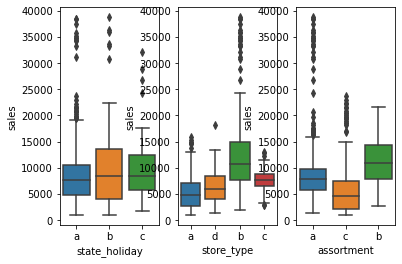

In [21]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1)

# 2 Feature engineering

In [22]:
df2 = df1.copy()

## 2.1 Mapa de hipóteses

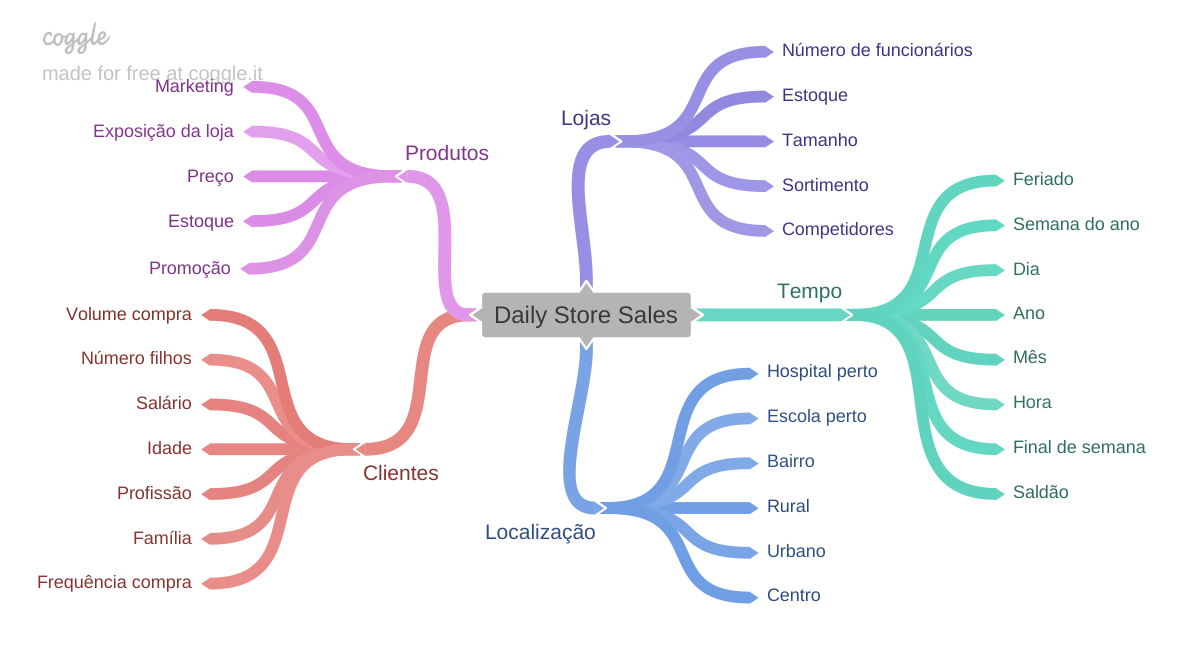

In [23]:
Image('img/HypothesisMindMap.png')

## 2.2 Criação das hipóteses

### 2.2.1 Sobre a loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores mais antigos deveriam vender mais.

### 2.2.2 Sobre os produtos

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas com maior exposição de vitrine deveriam vender mais.

**3.** Lojas com menores preços deveriam vender mais.

**4.** Lojas com promoções mais agressivas (maiores descontos) deveriam vender mais.

**5.** Lojas com promoções mais longas deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Sobre o tempo

**1.** Lojas abertas durante o natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender mais nos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Prioridade das hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores mais antigos deveriam vender mais.

**4.** Lojas com promoções mais longas deveriam vender mais.

**5.** Lojas com mais promoções consecutivas deveriam vender mais.

**6.** Lojas abertas durante o natal deveriam vender mais.

**7.** Lojas deveriam vender mais ao longo dos anos.

**8.** Lojas deveriam vender mais no segundo semestre.

**9.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**10.** Lojas deveriam vender mais nos finais de semana.

**11.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Criação das variáveis

In [24]:
# Ano
df2['year'] = df2['date'].apply(lambda x: x.year)

# Mês
df2['month'] = df2['date'].apply(lambda x: x.month)

# Dia
df2['day'] = df2['date'].apply(lambda x: x.day)

# Semana
df2['week_of_year'] = df2['date'].apply(lambda x: x.weekofyear)

# Data | ano-semana
df2['year_week'] = df2['date'].apply(lambda x: x.strftime('%Y-%W'))

In [25]:
# Competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
df2['competition_time_month'] = ((df2['date']-df2['competition_since'])).apply(lambda x: x.days/30).astype('int64')

In [26]:
# Promo since
df2['promo2_since'] = df2['promo2_since_year'].astype('str')+'-'+df2['promo2_since_week'].astype('str')
df2['promo2_since'] = df2['promo2_since'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%W'))
df2['promo_time_week'] = (df2['date']-df2['promo2_since']).apply(lambda x: x.days/7).astype('int64')

In [27]:
# Assortment | a = basic, b = extra, c = extended
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# State holiday | a = public holiday, b = Easter holiday, c = Christmas, 0 = None
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public holiday' if x == 'a' else 'easter holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular day')

# 3 Filtragem de variáveis

In [28]:
df3 = df2.copy()

## 3.1 Filtragem das linhas

In [31]:
df3 = df3[(df3['open'] == 1) & (df3['sales'] > 0)]

## 3.2 Seleção das colunas

In [33]:
drop_cols = ['customers', 'open', 'promo_interval', 'month_str']
df3.drop(drop_cols, axis = 1, inplace = True)

# 4 Análise exploratória de dados

In [35]:
df4 = df3.copy()

## 4.1 Análise univariada

### 4.1.1 Variável resposta

<AxesSubplot:xlabel='sales', ylabel='Count'>

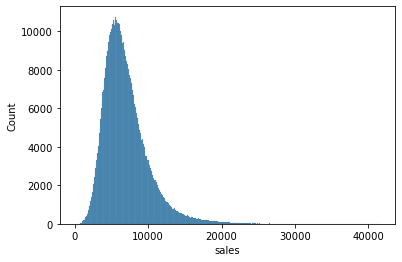

In [8]:
sns.histplot(df4['sales'], kde = False)

### 4.1.2 Variáveis numéricas

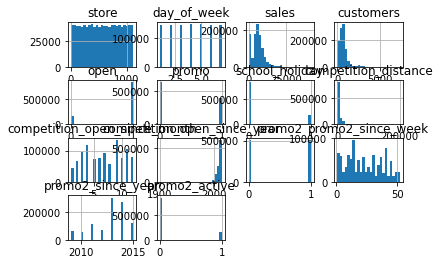

In [11]:
num_attributes.hist(bins = 25);

### 4.1.3 Variáveis categóricas

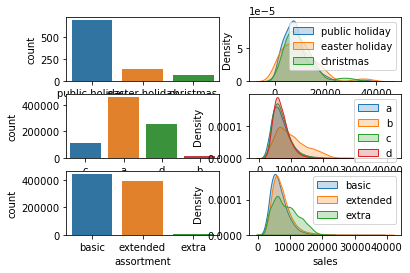

In [59]:
# State holiday
plt.subplot(3, 2, 1)
sns.countplot(x = 'state_holiday', data = df4[df4['state_holiday'] != 'regular day'])

plt.subplot(3, 2, 2)
sns.kdeplot(x = 'sales', data = df4[df4['state_holiday'] == 'public holiday'], label = 'public holiday', shade = True)
sns.kdeplot(x = 'sales', data = df4[df4['state_holiday'] == 'easter holiday'], label = 'easter holiday', shade = True)
sns.kdeplot(x = 'sales', data = df4[df4['state_holiday'] == 'christmas'], label = 'christmas', shade = True)
plt.legend()

# Store type
plt.subplot(3, 2, 3)
sns.countplot(x = 'store_type', data = df4)

plt.subplot(3, 2, 4)
sns.kdeplot(x = 'sales', data = df4[df4['store_type'] == 'a'], label = 'a', shade = True)
sns.kdeplot(x = 'sales', data = df4[df4['store_type'] == 'b'], label = 'b', shade = True)
sns.kdeplot(x = 'sales', data = df4[df4['store_type'] == 'c'], label = 'c', shade = True)
sns.kdeplot(x = 'sales', data = df4[df4['store_type'] == 'd'], label = 'd', shade = True)
plt.legend()

# Assortment
plt.subplot(3, 2, 5)
sns.countplot(x = 'assortment', data = df4)

plt.subplot(3, 2, 6)
sns.kdeplot(x = 'sales', data = df4[df4['assortment'] == 'basic'], label = 'basic', shade = True)
sns.kdeplot(x = 'sales', data = df4[df4['assortment'] == 'extended'], label = 'extended', shade = True)
sns.kdeplot(x = 'sales', data = df4[df4['assortment'] == 'extra'], label = 'extra', shade = True)
plt.legend()

## 4.2 Análise bivariada

## 4.3 Análise multivariada

# Atalho

## Importar dados

In [2]:
num_attributes = pd.read_csv('C:/Users/Lucas/Coding/DS/Kaggle/num_attributes.csv')

In [5]:
cat_attributes = pd.read_csv('C:/Users/Lucas/Coding/DS/Kaggle/cat_attributes.csv')

In [6]:
m = pd.read_csv('C:/Users/Lucas/Coding/DS/Kaggle/m.csv')

In [7]:
df4 = pd.read_csv('C:/Users/Lucas/Coding/DS/Kaggle/df4.csv')

## Exportar dados

In [44]:
num_attributes.to_csv('C:/Users/Lucas/Coding/DS/Kaggle/num_attributes.csv', index = False)

In [45]:
cat_attributes.to_csv('C:/Users/Lucas/Coding/DS/Kaggle/cat_attributes.csv', index = False)

In [47]:
m.to_csv('C:/Users/Lucas/Coding/DS/Kaggle/m.csv', index = False)

In [48]:
df4.to_csv('C:/Users/Lucas/Coding/DS/Kaggle/df4.csv', index = False)